In [1]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut
import functions

import time

## System initializer

In [2]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    #tank_current_loads = tank_max_loads.copy()
    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                                [0.2, 0.61, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.11, 0.33, 0.85],
                                                [0.09, 0.26, 0.9]
                                               ])
        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load 
    #tank_current_loads = tank_max_loads.copy()
    

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [3]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
#print([load for load in system.tank_loads])
print(system.graph)
print(system.weights)

[77, 143, 40, 307, 122]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  inf   inf   inf   inf   inf   inf]
 [  32.  159.  162.  156.  156.    0.]]


In [4]:
tanks[0].level_percentages

array([ 0.2 ,  0.61,  0.9 ])

### Reinitialize system function

In [5]:
verbose = False
print(system.tank_loads())
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

system = reinitialize_system(system,3)
print(system.tank_loads())
system = reinitialize_system(system,4)
print(system.tank_loads())
reward = system.random_action(seed = 1, verbose = verbose)
system.reset_trucks_positions();
#print(reward)
reward = system.random_action(seed = 1, verbose = verbose)
#print(reward)

[77, 143, 40, 307, 122]
[50.0, 182.0, 82.0, 457.0, 72.0]
[72.0, 180.0, 98.0, 594.0, 109.0]


## Q-learning algorithm (off-policy)


### Training

In [6]:
# Train parameters:
retrain = False
train_epsilon = False

learning_rate0 = 0.05 #??
learning_rate_decay = 0.01 #??

episodes = 10*10**6 #episodes
episodes_epsilon_min = 10**6 #5*10*6
train_freq = 10**4 # 10**4
episode_length = 30

discount_rate = 1

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 15

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [7]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print("Episode ", episode, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)

                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());    

                ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                #rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, "discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
   
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [8]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [9]:
if train_epsilon == True:
    #train_Q_epsilon()
    episodic_train_Q_epsilon()

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#Load trained Q-values
# if train == False:
#     simulation_id = 8
#     train_iterations = 20*10**5
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


# if retrain == False:
#     simulation_id = 7
#     train_iterations = 259*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

   
#test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
if train_epsilon == False:
    simulation_id = 15
    episodes =4820000
    
Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =100
test_freq = 1
test_verbose = True

test_visualization_steps = []
test_rewards_list = []

In [11]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        #reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


In [12]:
test_Q()
print(np.mean(test_rewards_list) )



Episode 1 t 0 -1990.80015977 5500
Episode 1 t 1 -1989.77241716 2400
Episode 1 t 2 -1991.91207799 2500
Episode 1 t 3 -1997.15707245 2400
Episode 1 t 4 -1983.98139674 4500
Episode 1 t 5 -1994.17663898 2500
Episode 1 t 6 -2986.39728399 0500
Episode 1 t 7 -3001.57080729 0300
Episode 1 t 8 -2005.38881865 0400
Episode 1 t 9 -1994.58452607 2400
Episode 1 t 10 -2001.09308442 5300
Episode 1 t 11 -2000.42755351 0400
Episode 1 t 12 -2012.07179884 5100
Episode 1 t 13 -2000.55932784 2400
Episode 1 t 14 -995.588886703 4000
Episode 1 t 15 -997.395385992 4000
Episode 1 t 16 -1991.26206106 2400
Episode 1 t 17 -1990.23249236 2500
Episode 1 t 18 -1987.19106423 4500
Episode 1 t 19 -2005.7064409 1400
Episode 1 t 20 -1002.28837798 5000
Episode 1 t 21 -1997.889979 2400
Episode 1 t 22 -2007.58125487 4100
Episode 1 t 23 -1003.40052634 5000
Episode 1 t 24 -2002.08153971 2400
Episode 1 t 25 -994.408395867 4000
Episode 1 t 26 -996.929882872 4000
Episode 1 t 27 -998.736382161 4000
Episode 1 t 28 -1992.60305722 240

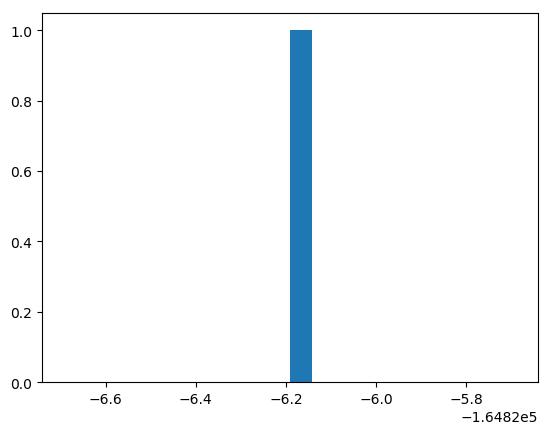

In [13]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()
#test_rewards_list

In [14]:
# Visualizing test simulation:
test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())



-164826.191667


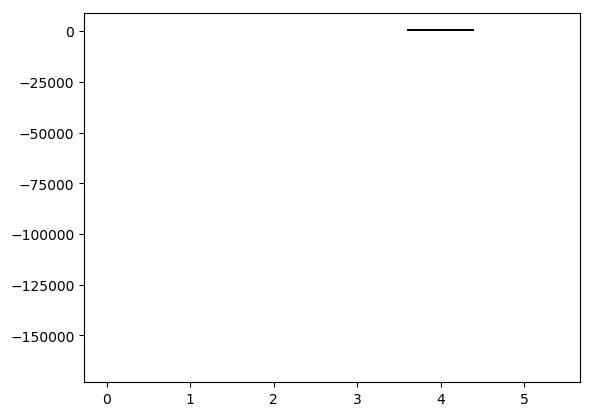

In [15]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
print(np.mean(test_rewards_list) )

plt.show()

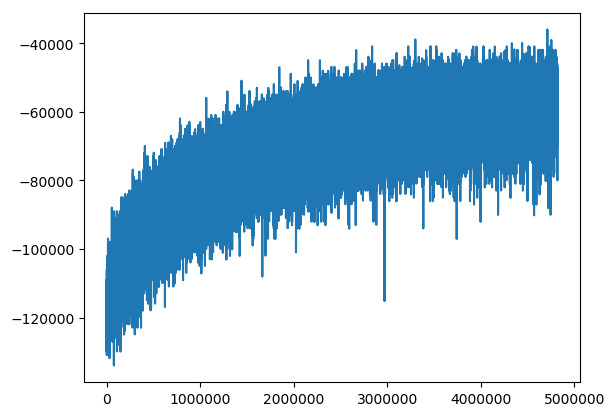

In [16]:
# Visualizing train simulation:

# train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
# HTML(train_anim.to_html5_video())

episode =4820000
simulation_id = 15
step = 100
discrewards_list = ut.load_obj("discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
             discrewards_list2)

#print(discrewards_list) 
plt.show()

In [17]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))

13927

In [18]:
list(range(0,len(discrewards_list),1000))

[0,
 1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39000,
 40000,
 41000,
 42000,
 43000,
 44000,
 45000,
 46000,
 47000,
 48000,
 49000,
 50000,
 51000,
 52000,
 53000,
 54000,
 55000,
 56000,
 57000,
 58000,
 59000,
 60000,
 61000,
 62000,
 63000,
 64000,
 65000,
 66000,
 67000,
 68000,
 69000,
 70000,
 71000,
 72000,
 73000,
 74000,
 75000,
 76000,
 77000,
 78000,
 79000,
 80000,
 81000,
 82000,
 83000,
 84000,
 85000,
 86000,
 87000,
 88000,
 89000,
 90000,
 91000,
 92000,
 93000,
 94000,
 95000,
 96000,
 97000,
 98000,
 99000,
 100000,
 101000,
 102000,
 103000,
 104000,
 105000,
 106000,
 107000,
 108000,
 109000,
 110000,
 111000,
 112000,
 113000,
 114000,
 115000,
 116000,
 117000,
 118000,
 119000,
 120000,
 121000,
 122000,
 12300

In [19]:
len(system.tanks_level[0])

4

In [20]:
Q

{'5500233130200': -214.87559067958509,
 '5500033023400': -171.50789240790019,
 '5500032002300': -1274.8691233770112,
 '5500031000300': -2457.046962154945,
 '5500030002000': -3959.816183863069,
 '5500032004200': -1277.5502974424655,
 '5500021000200': -3837.4770549783234,
 '5500020003200': -4977.6803429011834,
 '5500020001400': -3419.909086014703,
 '5500030012000': -2474.0267599949348,
 '5500031004100': -2949.2103337430522,
 '5500031001300': -3274.0239666623434,
 '5500030000100': -4956.676222652728,
 '5500030004000': -4803.8790115251904,
 '5500020000200': -4964.9039762222428,
 '5500020004100': -4815.7309453056832,
 '5500020001000': -5413.1936997342209,
 '5500020002200': -3989.6121342621273,
 '5500021003100': -3840.8807896471385,
 '5500021004100': -3695.5059380473199,
 '5500020003300': -3987.4649868600022,
 '5500010003000': -4803.1793293453893,
 '5500010003200': -4816.8061019108072,
 '5500010000200': -4807.5248151267542,
 '5500010000000': -4783.0079279457077,
 '5500010005300': -3874.65089